In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import bz2
from scipy.misc import imsave, imrotate


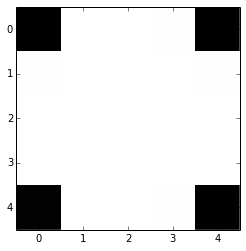

1.0
0.047619047619


In [15]:
imgw = imgh = 32
ballw = ballh = 5
hbw, hbh = ballw//2, ballh//2

ball = np.zeros((ballh, ballw))
ball[1:-1, :] = 255.
ball[:, 1:-1] = 255.
plt.figure()
plt.imshow(ball, interpolation='none', cmap='Greys_r')
plt.show()

new_ball = ball/np.sum(ball)
print ( np.sum(new_ball) )
print ( np.sum(new_ball**2) )


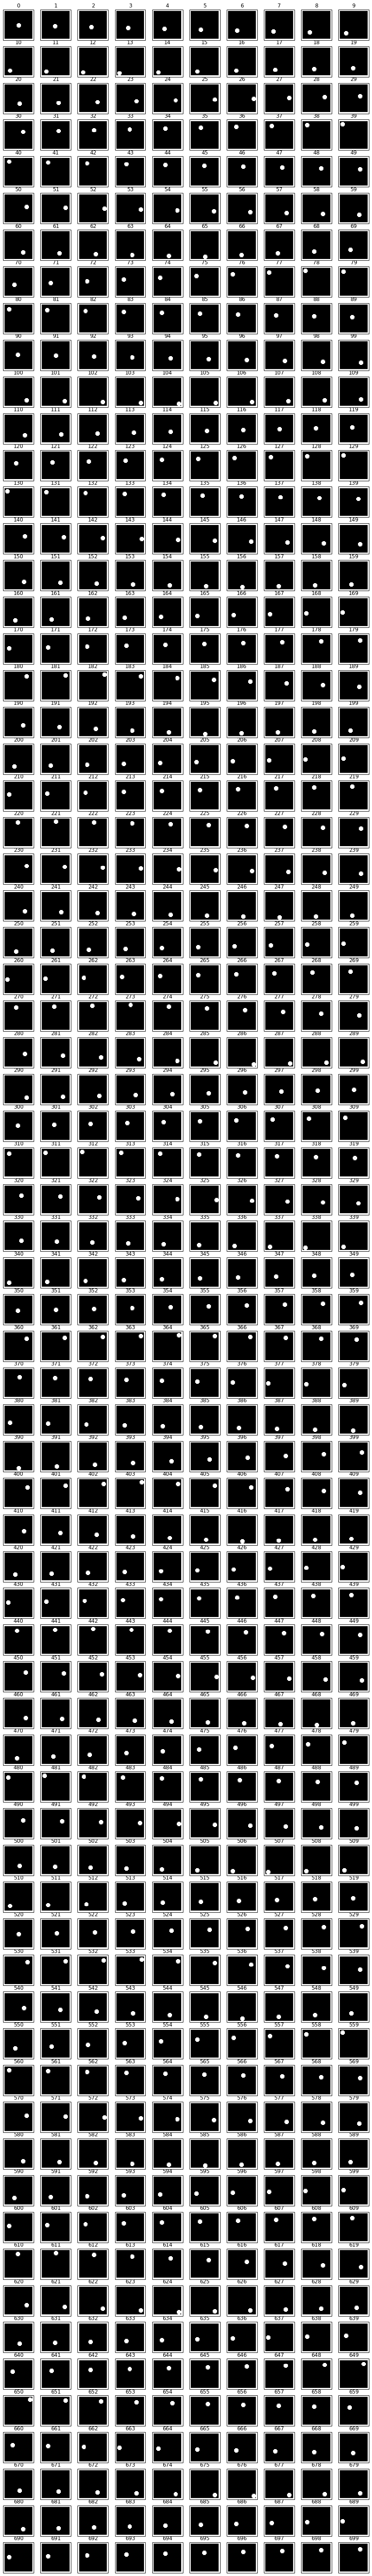

In [16]:
np.random.seed()
fps = 70.
tpf = 1000. / fps
ballx, bally = imgw//2, imgh//2
dx = int(np.round(np.random.uniform(-1., 1.)))
dx = 1 if dx == 0 else dx
dy = int(np.round(np.random.uniform(-1., 1.)))
dy = 1 if dy == 0 else dy
if not os.path.isdir("./bouncing_ball_sequence_w_%03d_h_%03d_bw_%02d"%(imgw, imgh, ballw)):
    os.makedirs("./bouncing_ball_sequence_w_%03d_h_%03d_bw_%02d"%(imgw, imgh, ballw))

frame = np.zeros((imgh, imgw))
frames = int(fps * 10)
fw = 1.5
cols = 10
rows = frames // cols + int((frames % cols) > 0)
plt.figure(figsize=(cols * fw, rows * fw))
for i in range(frames):
    frame[:] = 0
#     print("x: %d, y:%d, dx: %d, dy: %d"%(ballx, bally, dx, dy))
#     print("%d:%d, %d:%d"%(bally-hbh, bally+hbh+1, ballx-hbw,ballx+hbw+1))
    frame[bally-hbh:bally+hbh+1, ballx-hbw:ballx+hbw+1] = ball
    
    ballx += dx
    bally += dy
    
    if (ballx - hbw + dx) <= 0 or (ballx + hbw + dx) >= imgw:
        sign = 1 if dx < 0 else -1
        dx = sign * int(np.round(np.random.uniform(1., 2.)))
        
    if (bally - hbh + dy) <= 0 or (bally + hbh + dy) >= imgh:
        sign = 1 if dy < 0 else -1
        if abs(dx) > 1:
            dy = sign
        else:
            dy = sign * int(np.round(np.random.uniform(1., 2.)))
        
        
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(frame.copy(), cmap='Greys_r', interpolation='none')
    ax.set_title("%d"%(i))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.margins(0.05, 0.05)
    

    imsave("./bouncing_ball_sequence_w_%03d_h_%03d_bw_%02d/ball_%06d.png"%(imgw, imgh, ballw, i), frame)
plt.show()

In [17]:
print 1000./70.
print 64 // 4 

14.2857142857
16


In [18]:
def load_compressed_spikes(name):
    fname = os.path.join(os.getcwd(), '%s.bz2'%name)
    print(fname)
    spikes = []
    with bz2.BZ2File(fname, 'rb') as f:
        for line in f:
            spl = line.split(' ')
            spikes.append((int(float(spl[0])), float(spl[1])))
            
        return spikes
    
def rowcol(indices,  row_bits=5, col_bits=5, chann_bits=1):
    '''from X | Y | P'''
    row = np.bitwise_and(
            np.right_shift(indices, chann_bits), ((1 << row_bits) - 1))
    col = np.bitwise_and(
            np.right_shift(indices, (row_bits + chann_bits)), ((1 << col_bits) - 1))
    print(np.unique(col))
    chn = np.bitwise_and(indices, ((1 << chann_bits) - 1))
    return row, col, chn


def split_in_spikes(spikes, row_bits=5, col_bits=5, chann_bits=1, width=32):
    rows, cols, chans = rowcol(np.array([np.uint32(i) for i, _ in spikes]), 
                               row_bits=row_bits, col_bits=col_bits, 
                               chann_bits=chann_bits)
#     print(rows, cols, chans)
    full_times = np.array([t for _, t in spikes])
    on_indices = np.where(chans == 1)[0]
    on_ids = rows[on_indices]*width + cols[on_indices]
    on_ts = full_times[on_indices]
    
    off_indices = np.where(chans == 0)[0]
    off_ids = rows[off_indices]*width + cols[off_indices]
    off_ts = full_times[off_indices]
    
    on_spks = sorted([[on_ids[i], on_ts[i]] for i in range(len(on_ts))], 
                     key=lambda x: x[1])
    off_spks = sorted([[off_ids[i], off_ts[i]] for i in range(len(off_ts))], 
                      key=lambda x: x[1])

    return on_spks, off_spks


def img_map(idx, width, n_per_coord=1):
    row = idx // (width*n_per_coord)
    col = (idx - row*width*n_per_coord) // n_per_coord
    return row, col


def spikes_to_images(on_spikes, off_spikes, width, height, n_per_coord=1, 
                     dt=11, cols=10):
    max_t = np.max([t for _, t in on_spikes])
    print "on_spikes length = ", len(on_spikes)
    if off_spikes is not None:
        max_t = max(max_t, np.max([t for _, t in off_spikes]))
        print "off_spikes length = ", len(off_spikes)
    max_t = int(max_t)
    
    img = np.zeros((height, width, 3))
    imgs = []
    start_t = 0
    on_start = 0
    off_start = 0
    for start_t in range(0, max_t, dt):
        end_t = start_t + dt
        for i, spike in enumerate(on_spikes[on_start:]):
            idx, t = spike
            if start_t <= t and t < end_t:
                row, col = img_map(idx, width, n_per_coord)
                img[row, col, 1] += 10.
            else:
                on_start += i
                break
        
        
        if off_spikes is not None:
            for j, spike in enumerate(off_spikes[off_start:]):
                idx, t = spike
                if start_t <= t and t < end_t:
                    row, col = img_map(idx, width, n_per_coord)
                    img[row, col, 0] += 10.
                else:
                    off_start += j
                    break
        

        imgs.append(img.copy())
        img[:] = 0.

    return imgs

In [29]:
fname = '/opt/Copy/Doctorado_SpiNNaker/SpiNNaker/pyDVS/bouncing_ball_sequence_w_032_h_032_bw_05/'\
'behave_SACCADE_pol_MERGED_enc_TIME_thresh_13_hist_99_00_inh_False_at_71fps_32x32_res_spikes/spikes.txt'
spikes = load_compressed_spikes(fname)

spk_on, spk_off = split_in_spikes(spikes, row_bits=5, col_bits=5, chann_bits=1, 
                                  width=32)





/opt/Copy/Doctorado_SpiNNaker/SpiNNaker/pyDVS/bouncing_ball_sequence_w_032_h_032_bw_05/behave_SACCADE_pol_MERGED_enc_TIME_thresh_13_hist_99_00_inh_False_at_71fps_32x32_res_spikes/spikes.txt.bz2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]


In [30]:
imgs = spikes_to_images(spk_on, spk_off, 32, 32, dt=14)

on_spikes length =  11611
off_spikes length =  11392


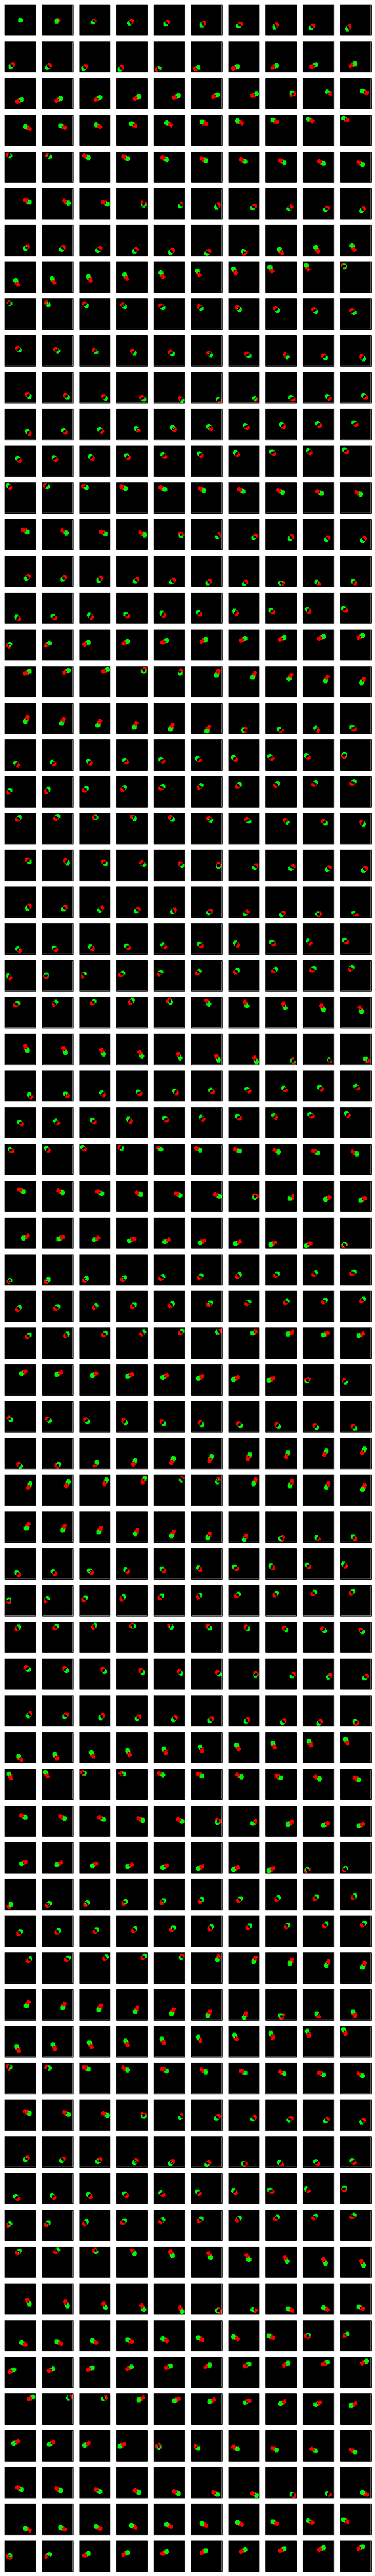

In [31]:
cols = 10
rows = len(imgs)//cols + int(len(imgs)%cols > 0)
fig = plt.figure(figsize=(cols, rows))
for i, img in enumerate(imgs):
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()